 # Double Deep Q Networks

 ## Imports

In [1]:
import gym, math, glob
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta

import torch
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from utils.wrappers import *
from networks.networks import DQN
from agents.DQN import Model as DQN_Agent
from networks.network_bodies import AtariBody
from utils.ReplayMemory import ExperienceReplayMemory

from utils.hyperparameters import Config
from utils.plot import plot_reward


 ## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#epsilon variables
config.epsilon_start = 1.0
config.epsilon_final = 0.01
config.epsilon_decay = 30000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 100000
config.BATCH_SIZE = 32

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=1000000
config.UPDATE_FREQ = 1

#Nstep controls
config.N_STEPS=1


 ## Agent

In [3]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None):
        super(Model, self).__init__(static_policy, env, config)

    def get_max_next_state_action(self, next_states):
        return self.model(next_states).max(dim=1)[1].view(-1, 1)


 ## Training Loop

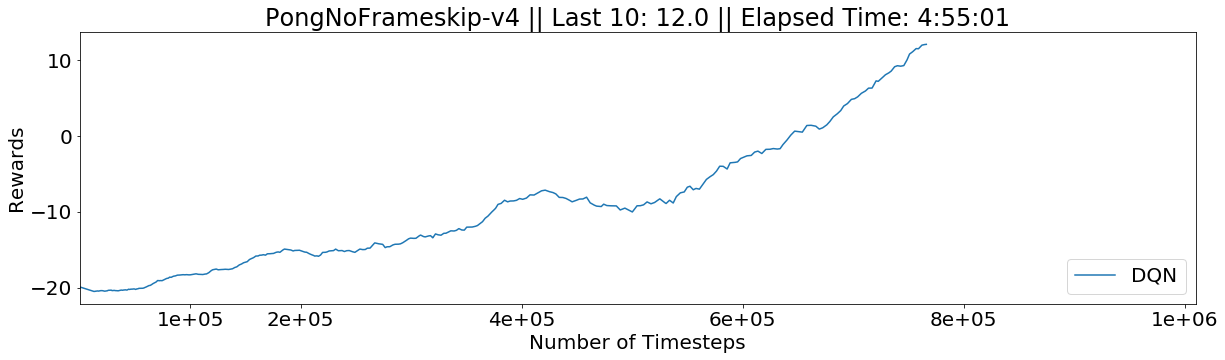

In [ ]:
start=timer()

log_dir = "/tmp/gym/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv'))
    for f in files:
        os.remove(f)

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = bench.Monitor(env, os.path.join(log_dir, env_id))
env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=True)
env    = WrapPyTorch(env)
model  = Model(env=env, config=config)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward
    
    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0

    if frame_idx % 10000 == 0:
        try:
            clear_output(True)
            plot_reward(log_dir, env_id, 'DQN', config.MAX_FRAMES, bin_size=10, smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()


